#Import Libraries

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Step 1: Data Preparation

In [ ]:
# Sample parallel sentences (English -> Spanish)
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

# Next we convert the text from the sentences to tokens and create a vocabulary

In [ ]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Now pad the corresponding sentences

In [ ]:
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

# Prepare the target data for training

In [ ]:
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]



# Convert to one-hot

In [ ]:
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

# Step 2: Self-Attention Layer

In [ ]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Step 3: Model Architecture

In [ ]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention: decoder attends to encoder outputs
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final Dense layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 5, 256)    │      4,096 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 5, 256)    │      4,352 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 5, 256)    │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 512)    │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 17)     │      8,721 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,068,049 (4.07 MB)

 Trainable params: 1,068,049 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

# Step 4: Training the Model

In [ ]:
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0400 - loss: 2.8335
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3600 - loss: 2.8019
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3200 - loss: 2.7682
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3200 - loss: 2.7294
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3200 - loss: 2.6815
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2800 - loss: 2.6199
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2800 - loss: 2.5384
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2800 - loss: 2.4309
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2800 - loss: 2.2976
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2400 - loss: 2.1660
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2400 - loss: 2.1001
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2400 - lo

# Step 5: Plotting the training loss

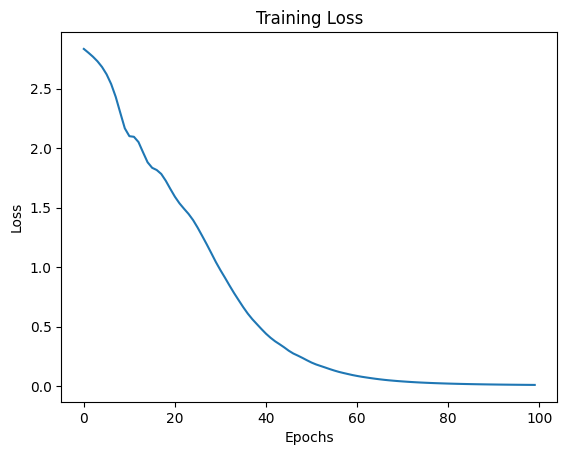

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()